In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import re
from liftover import get_lifter
import seaborn as sns
import networkx as nx
import pickle
sys.path.append("/n/holystore01/LABS/liau_lab/Users/heejinroh/Yan_minimap/code/100224")
#sys.path.append("/n/holShgmlystore01/LABS/liau_lab/Users/heejinroh/Yan_minimap/tdac-seq/tdac_seq")
#from ddda_dataset_dedup_2 import *
from ddda_dataset import *
%matplotlib inline
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec

In [5]:
fastq_files = {
    "ddda_data_1": "/n/holystore01/LABS/liau_lab/Users/heejinroh/HJR313/HJR313_4/HJR313_4.fastq.gz",
    "ddda_data_2": "/n/holystore01/LABS/liau_lab/Users/heejinroh/HJR313/HJR313_5/HJR313_5.fastq.gz",
    "ddda_data_3": "/n/holystore01/LABS/liau_lab/Users/heejinroh/HJR313/HJR313_6/HJR313_6.fastq.gz"
}

# Reference region dictionary (same for all)
ref_range_dict = {
    'HBB': ('chr11', 5223731, 5235754)
}

# Directories and genome file
working_base_dir = "/n/holystore01/LABS/liau_lab/Users/heejinroh/Yan_minimap/analysis/HJR234"
genome_file = "/n/holystore01/LABS/liau_lab/Users/heejinroh/Genome/GCA_000001405.15_GRCh38_no_alt_analysis_set.fna"
bias_model_path = "/n/holystore01/LABS/liau_lab/Users/heejinroh/Yan_minimap/code/bias_dict.pkl"

# Create plot directory
plot_dir = os.path.join(working_base_dir, "plot")
os.system("mkdir -p " + plot_dir)

# Dictionary to hold all ddda_data objects
ddda_data_dict = {}

# Iterate over each FASTQ and process
for var_name, fastq_path in fastq_files.items():
    ddda_data = ddda_dataset(
        ID=var_name,
        region_dict=ref_range_dict,
        genome_file=genome_file,
        fastq_file=fastq_path,
        working_dir=working_base_dir
    )

    # Load DddA bias model
    with open(bias_model_path, "rb") as f:
        ddda_data.bias_model = pickle.load(f)

    # Align reads
    ddda_data.align_reads(
        start_gap_threshold=500,
        end_gap_threshold=500
    )

    # Store in dictionary under the correct variable name
    ddda_data_dict[var_name] = ddda_data

Loading reference genome
Extracting sequences for each locus


100%|██████████| 112866/112866 [04:07<00:00, 456.80it/s]
/n/home07/heejinroh/.conda/envs/liftover2/lib/python3.10/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Loading reference genome
Extracting sequences for each locus


100%|██████████| 42901/42901 [01:33<00:00, 456.67it/s]
/n/home07/heejinroh/.conda/envs/liftover2/lib/python3.10/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


Loading reference genome
Extracting sequences for each locus


100%|██████████| 59997/59997 [02:10<00:00, 458.09it/s]
/n/home07/heejinroh/.conda/envs/liftover2/lib/python3.10/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [8]:
locus = "HBB"
min_num=10000
sample_ids = ["ddda_data_1", "ddda_data_2", "ddda_data_3"]

# Output dictionaries
all_edits = {}
all_track_undeleted_ac_smoothed = {}

for sample_id in sample_ids:
    ddda_data = ddda_data_dict[sample_id]

    # Randomly sample undeleted reads
    undel_read_ids = np.random.choice(np.array(ddda_data.read_ids[locus]), min_num, replace=False)
    undel_read_ids = ddda_data.dedup_reads(locus=locus, read_ids=undel_read_ids)
    undel_read_inds = np.array([ddda_data.read_ids[locus].index(i) for i in undel_read_ids])

    selected_read_inds = undel_read_inds
    selected_reads = np.array(ddda_data.read_ids[locus])[selected_read_inds]

    # Strand separation
    strands = ddda_data.read_strands[locus][selected_read_inds]
    CtoT_inds = selected_read_inds[strands == 0]
    GtoA_inds = selected_read_inds[strands == 1]

    CtoT_reads = np.array(ddda_data.read_ids[locus])[CtoT_inds]
    GtoA_reads = np.array(ddda_data.read_ids[locus])[GtoA_inds]

    # Edits
    CtoT_edits = np.array(ddda_data.edit_dict[locus][CtoT_inds, :].todense())
    GtoA_edits = np.array(ddda_data.edit_dict[locus][GtoA_inds, :].todense())
    edits = np.array(ddda_data.edit_dict[locus][selected_read_inds, :].todense())

    # Reorder by edit count
    read_edit_num = np.sum(edits, axis=1)
    row_order = np.argsort(-read_edit_num)
    edits = edits[row_order, :]

    # Track
    track_undeleted_ac = np.mean(edits, axis=0)
    track_undeleted_ac_smoothed = np.convolve(track_undeleted_ac, np.ones(50) / 50, mode='same')

    # Store results
    all_edits[sample_id] = edits
    all_track_undeleted_ac_smoothed[sample_id] = track_undeleted_ac_smoothed

100%|██████████| 10000/10000 [00:03<00:00, 3219.46it/s]
10000it [00:00, 1139230.25it/s]
100%|██████████| 10000/10000 [00:03<00:00, 3210.41it/s]
10000it [00:00, 1170775.72it/s]
100%|██████████| 10000/10000 [00:03<00:00, 3189.06it/s]
10000it [00:00, 1128380.73it/s]


In [10]:
plot_range = np.arange(500, 5235754-5223731-500)

In [15]:
ymax = max(max(all_track_undeleted_ac_smoothed['ddda_data_1']),max(all_track_undeleted_ac_smoothed['ddda_data_2']),max(all_track_undeleted_ac_smoothed['ddda_data_3']))

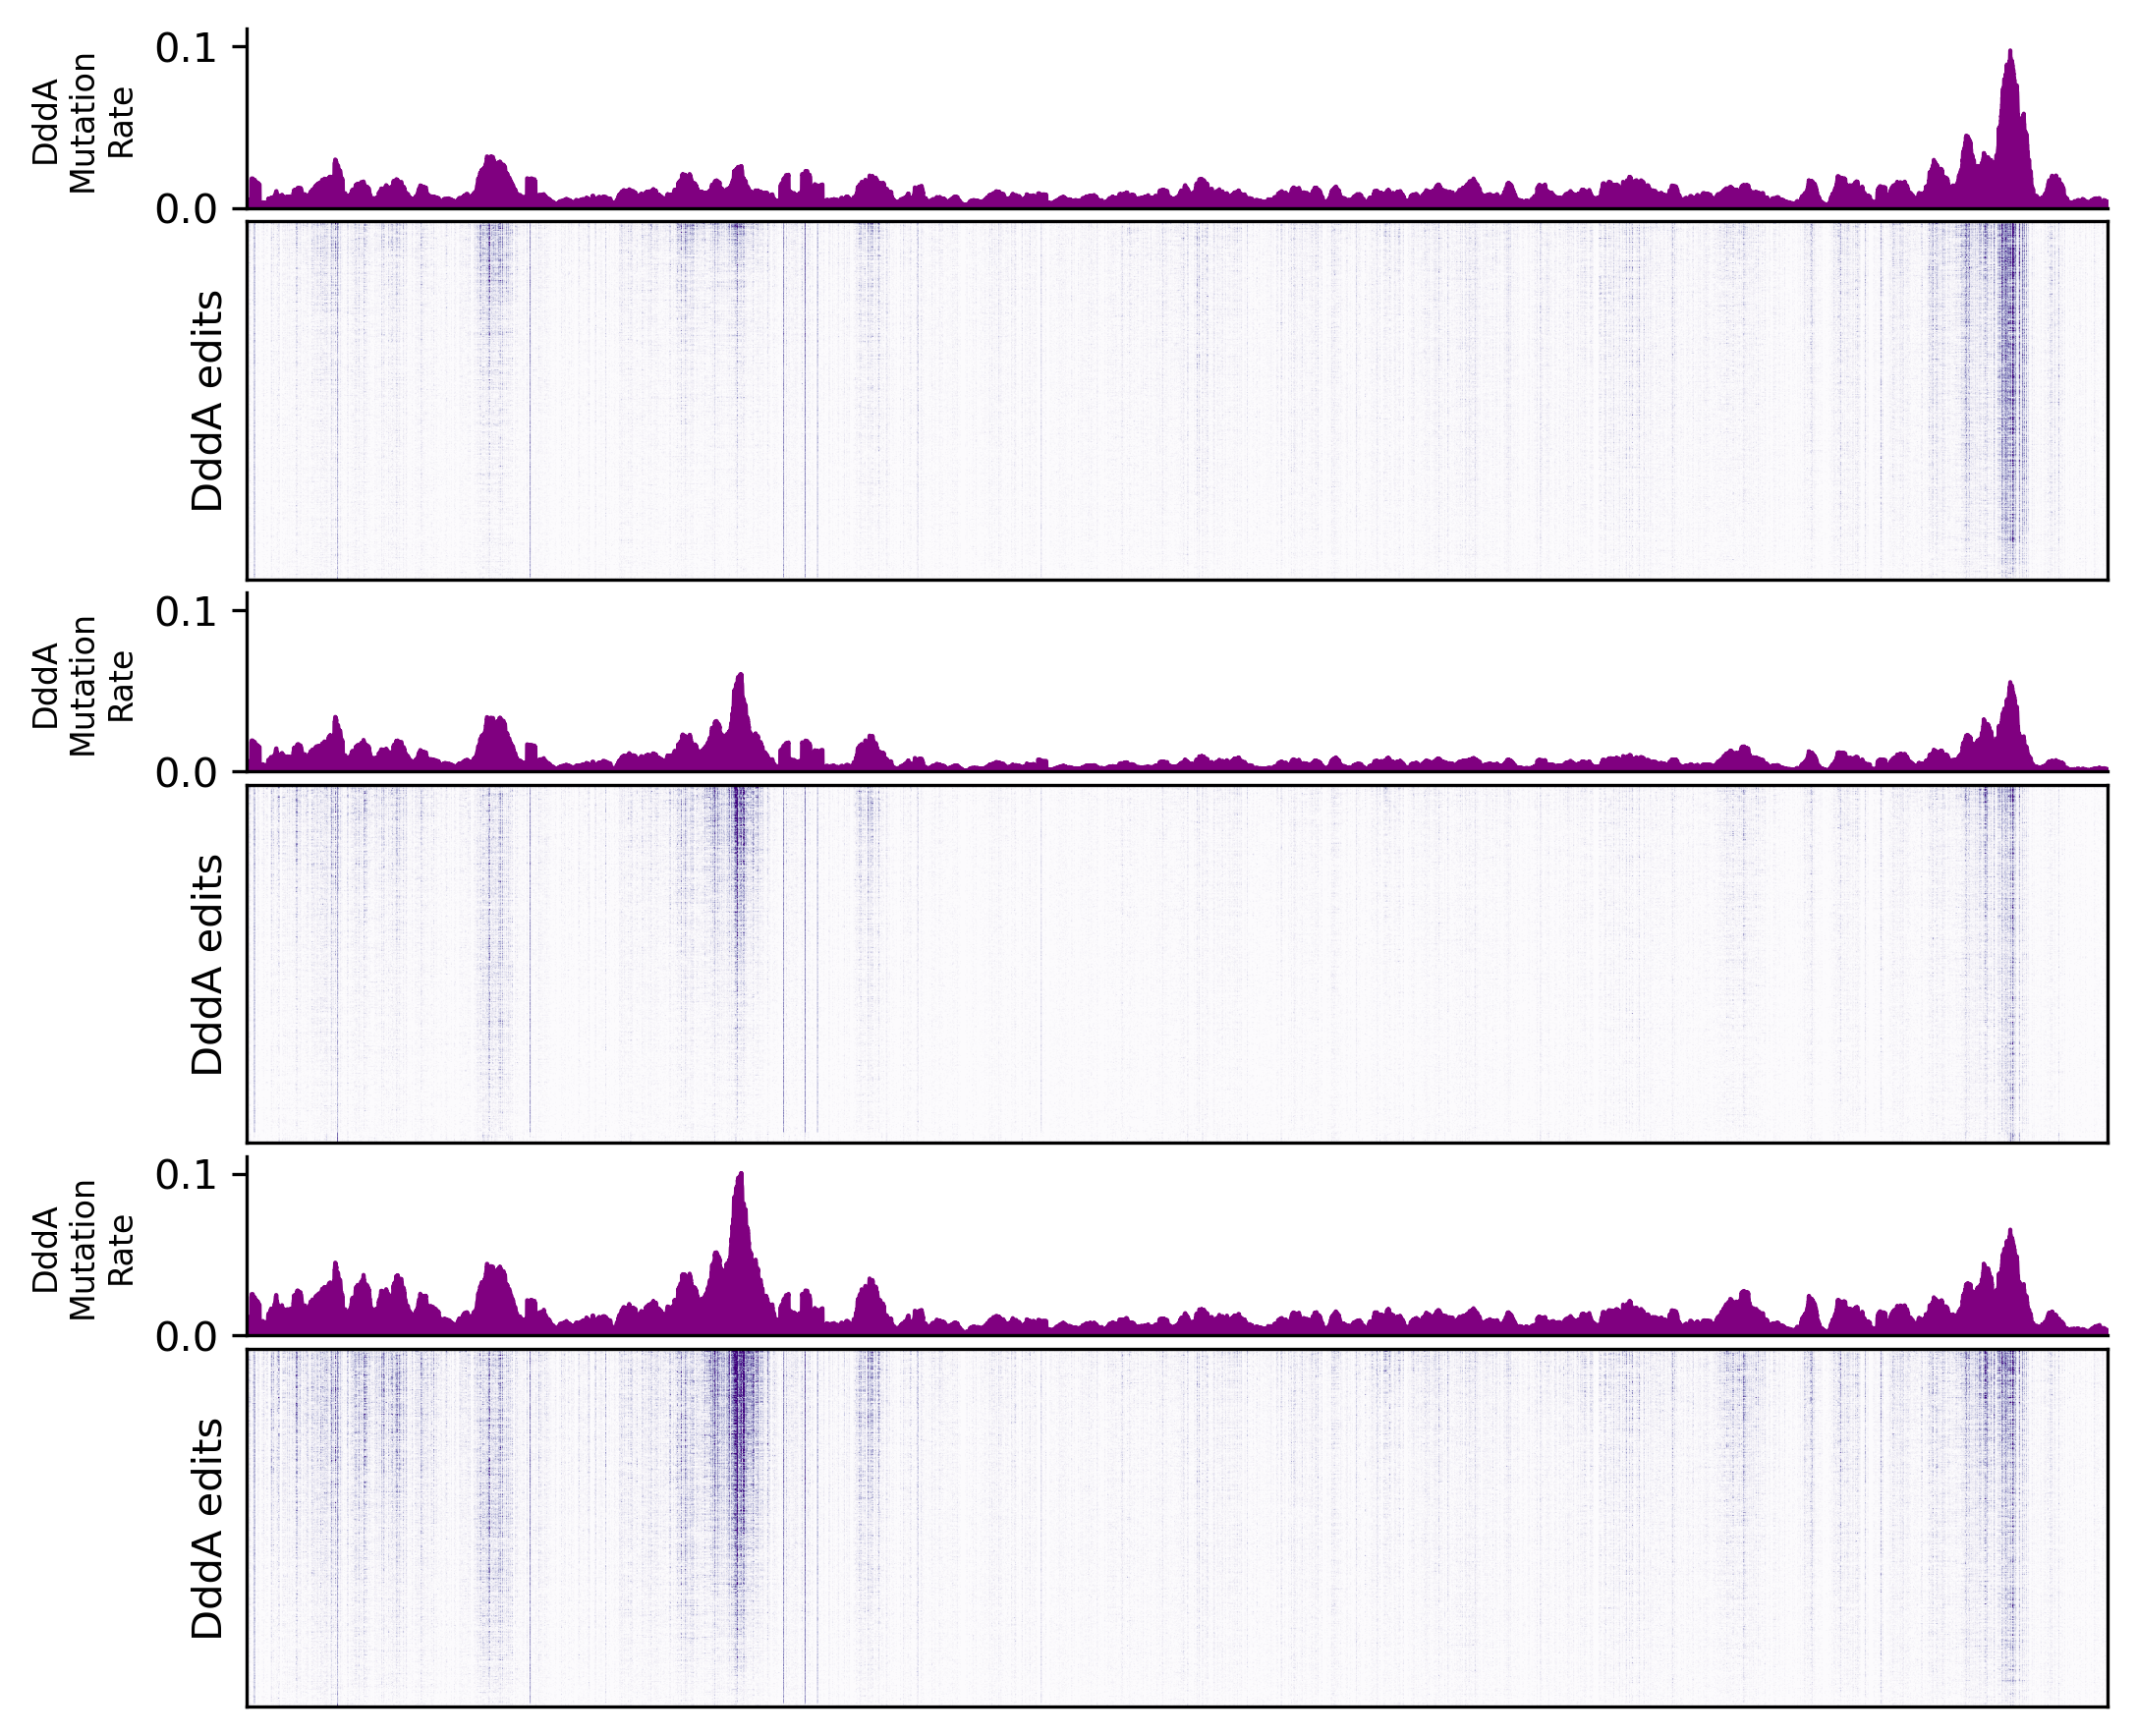

In [20]:
import matplotlib.gridspec as gridspec
import matplotlib.colorbar as cbar
from matplotlib.colors import LinearSegmentedColormap

fig = plt.figure(dpi=300,figsize=(8,6 ))  # Adjusted the figure size to accommodate four plots
gs = gridspec.GridSpec(6, 1, height_ratios=[0.5, 1, 0.5, 1, 0.5, 1])  # Adjusted to four rows

# First subplot (now second)
ax0 = plt.subplot(gs[0])
x_values = np.arange(len(all_track_undeleted_ac_smoothed['ddda_data_1'][plot_range]))
ax0.fill_between(x_values, all_track_undeleted_ac_smoothed['ddda_data_1'][plot_range], color='purple', alpha=1)
ax0.set_xlim([x_values.min(), x_values.max()])
ax0.set_ylim([0, ymax * 1.1])
ax0.set_xticks([])  # Remove x-axis ticks
ax0.set_xlabel('')
ax0.set_ylabel('DddA\nMutation\nRate', fontsize=8)

# Remove box outline and keep x and y axis
ax0.spines['top'].set_visible(False)
ax0.spines['right'].set_visible(False)

# Second subplot (now third)
ax1 = plt.subplot(gs[1])
ax1.imshow(all_edits['ddda_data_1'][:, plot_range], aspect='auto', vmax=0.2, vmin=0, cmap='Purples')
ax1.set_ylabel('DddA edits')
ax1.set_xticks([])  # Remove x-axis ticks
ax1.set_yticks([])  # Remove y-axis ticks
ax1.set_xlabel('')

# First subplot (now second)
ax2 = plt.subplot(gs[2])
x_values = np.arange(len(all_track_undeleted_ac_smoothed['ddda_data_2'][plot_range]))
ax2.fill_between(x_values, all_track_undeleted_ac_smoothed['ddda_data_2'][plot_range], color='purple', alpha=1)
ax2.set_xlim([x_values.min(), x_values.max()])
ax2.set_ylim([0, ymax * 1.1])
ax2.set_xticks([])  # Remove x-axis ticks
ax2.set_xlabel('')
ax2.set_ylabel('DddA\nMutation\nRate', fontsize=8)

# Remove box outline and keep x and y axis
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# Second subplot (now third)
ax3 = plt.subplot(gs[3])
ax3.imshow(all_edits['ddda_data_2'][:, plot_range], aspect='auto', vmax=0.2, vmin=0, cmap='Purples')
ax3.set_ylabel('DddA edits')
ax3.set_xticks([])  # Remove x-axis ticks
ax3.set_yticks([])  # Remove y-axis ticks
ax3.set_xlabel('')


# First subplot (now second)
ax4 = plt.subplot(gs[4])
x_values = np.arange(len(all_track_undeleted_ac_smoothed['ddda_data_3'][plot_range]))
ax4.fill_between(x_values, all_track_undeleted_ac_smoothed['ddda_data_3'][plot_range], color='purple', alpha=1)
ax4.set_xlim([x_values.min(), x_values.max()])
ax4.set_ylim([0, ymax * 1.1])
ax4.set_xticks([])  # Remove x-axis ticks
ax4.set_xlabel('')
ax4.set_ylabel('DddA\nMutation\nRate', fontsize=8)

# Remove box outline and keep x and y axis
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)

# Second subplot (now third)
ax5 = plt.subplot(gs[5])
ax5.imshow(all_edits['ddda_data_3'][:, plot_range], aspect='auto', vmax=0.2, vmin=0, cmap='Purples')
ax5.set_ylabel('DddA edits')
ax5.set_xticks([])  # Remove x-axis ticks
ax5.set_yticks([])  # Remove y-axis ticks
ax5.set_xlabel('')

plt.tight_layout()  # Adjust layout
plt.subplots_adjust(hspace=0.05, right=0.9)  # Adjust space between plots and leave room for colorbar

#plt.savefig('/n/holystore01/LABS/liau_lab/Users/heejinroh/Yan_minimap/analysis/HJR234/HJR313_accessibility_max0.2.pdf', format='pdf')

plt.show()